### **Importing Libraries**


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

### **Scraping the NYC TLC Trip record webpage**

In [ ]:
##Current version


import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL of the TLC Trip Record Data page
url = 'https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page'

# Send a GET request
response = requests.get(url)

# Parse the HTML content
soup = BeautifulSoup(response.text, 'html.parser')

# Find the links (you need to update the selector based on the actual page structure)
links = soup.find_all('a')

# Filter links for Yellow Taxi and a specific year, adjust the conditions based on actual link text or URL structure
yellow_taxi_links = [link['href'] for link in links if 'yellow' in link['href'] and '2023' in link['href']]  # Considering data for 2023


In [ ]:
yellow_taxi_links

['https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-03.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-04.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-05.parquet ',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-06.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-07.parquet ',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-08.parquet ',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-09.parquet ',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-10.parquet ',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-11.parquet ',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023

Collected the links of NYC TLC Taxi trip data for each month of 2023.

In [ ]:
from pathlib import Path

from typing import Optional, List, Tuple

def extract_one_file_of_raw_data(url) -> Path:
    """
    Extract Parquet file with historical taxi rides for the links we obatined in the above step
    """
    url_lst = url.split('/')
    URL = url_lst[0]+'/' + url_lst[1] +'/'+  url_lst[2]+'/' + url_lst[3] + '/'+ url_lst[4]
    URL = URL.strip()
    response = requests.get(URL)

    if response.status_code == 200:
        fname = URL.split('/')[4]
        path = fname
        open(path, "wb").write(response.content)
        return path
    else:
        raise Exception(f'{URL} is not available')

fnames =  []

#Extracting first, second and third month (January, February and March) of the Trip Data 2023

for url in yellow_taxi_links[0:3]:
  fname = extract_one_file_of_raw_data(url)
  fnames.append(fname)


fnames




['yellow_tripdata_2023-01.parquet',
 'yellow_tripdata_2023-02.parquet',
 'yellow_tripdata_2023-03.parquet']

Extracted and saved two months (January and February) of trip data in 2023

In [ ]:
def extract_year_month(fname) -> Tuple:
  year, month = fname.split('_')[2].split('.')[0].split('-')
  return int(year),int(month)



In [ ]:
def validate_raw_data(
    rides: pd.DataFrame,
    year: int,
    month: int,
) -> pd.DataFrame:
    """
    Removes rows with pickup_datetimes outside their valid range
    """
    # keep only rides for this month
    this_month_start = f'{year}-{month}-01'
    next_month_start = f'{year}-{month+1}-01' if month < 12 else f'{year+1}-01-01'
    rides = rides[rides.pickup_datetime >= this_month_start]
    rides = rides[rides.pickup_datetime < next_month_start]

    return rides

In [ ]:
def load_raw_data() -> pd.DataFrame:
    """
    Loads raw data from local storage or downloads it from the NYC website, and
    then loads it into a Pandas DataFrame

    Args:
        year: year of the data to download
        months: months of the data to download. If `None`, download all months

    Returns:
        pd.DataFrame: DataFrame with the following columns:
            - pickup_datetime: datetime of the pickup
            - pickup_location_id: ID of the pickup location
    """
    rides = pd.DataFrame()


    for file in fnames:

        # load the file into Pandas
        rides_one_month = pd.read_parquet(file)

        # rename columns
        #rides_one_month = rides_one_month[['tpep_pickup_datetime', 'PULocationID']]

        rides_one_month.columns = [col.lower()  for col in rides_one_month.columns]

        rides_one_month.rename(columns={
            'tpep_pickup_datetime': 'pickup_datetime',
            'pulocationid': 'pickup_location_id',
        }, inplace=True)

        year,month = extract_year_month(file)

        # validate the file
        rides_one_month = validate_raw_data(rides_one_month, year, month)

        # append to existing data
        rides = pd.concat([rides, rides_one_month])

    if rides.empty:
        # no data, so we return an empty dataframe
        return pd.DataFrame()
    else:
        # keep only time and origin of the ride
        #rides = rides[['pickup_datetime', 'pickup_location_id']]
        return rides


In [ ]:
nyc_data = load_raw_data()

In [ ]:
nyc_data.shape

(9384195, 19)

First three months of 2023 year has around 9.38 Million trips

In [ ]:
nyc_data.head()

,vendorid,pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pickup_location_id,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


### **Missing Values Analysis**

In [ ]:
(nyc_data.isnull().sum()* 100)/ nyc_data.shape[0]

,0
vendorid,0.000000
pickup_datetime,0.000000
tpep_dropoff_datetime,0.000000
passenger_count,2.516774
trip_distance,0.000000
ratecodeid,2.516774
store_and_fwd_flag,2.516774
pickup_location_id,0.000000
dolocationid,0.000000
payment_type,0.000000


In [ ]:
nyc_data.shape

(9384195, 19)

**Rows containing Nans and needs cleaning**

In [ ]:
nyc_data[nyc_data['passenger_count'].isna()].head()

,vendorid,pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pickup_location_id,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
2995023,1,2023-01-01 00:02:40,2023-01-01 00:30:36,NaN,0.00,NaN,None,142,79,0,20.13,0.0,0.5,0.00,0.0,1.0,24.13,NaN,NaN
2995024,1,2023-01-01 00:57:48,2023-01-01 01:12:34,NaN,0.00,NaN,None,237,263,0,12.00,1.0,0.5,2.55,0.0,1.0,21.55,NaN,NaN
2995025,2,2023-01-01 00:55:37,2023-01-01 01:00:41,NaN,0.86,NaN,None,24,41,0,12.80,0.0,0.5,2.14,0.0,1.0,16.44,NaN,NaN
2995026,2,2023-01-01 00:43:47,2023-01-01 00:56:12,NaN,5.36,NaN,None,88,229,0,24.51,0.0,0.5,4.28,0.0,1.0,32.79,NaN,NaN
2995027,2,2023-01-01 00:34:00,2023-01-01 00:51:00,NaN,6.03,NaN,None,232,263,0,32.30,0.0,0.5,7.26,0.0,1.0,43.56,NaN,NaN


In [ ]:
nyc_data[nyc_data['passenger_count'].isna()]

,vendorid,pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pickup_location_id,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
2995023,1,2023-01-01 00:02:40,2023-01-01 00:30:36,NaN,0.00,NaN,None,142,79,0,20.13,0.0,0.5,0.00,0.0,1.0,24.13,NaN,NaN
2995024,1,2023-01-01 00:57:48,2023-01-01 01:12:34,NaN,0.00,NaN,None,237,263,0,12.00,1.0,0.5,2.55,0.0,1.0,21.55,NaN,NaN
2995025,2,2023-01-01 00:55:37,2023-01-01 01:00:41,NaN,0.86,NaN,None,24,41,0,12.80,0.0,0.5,2.14,0.0,1.0,16.44,NaN,NaN
2995026,2,2023-01-01 00:43:47,2023-01-01 00:56:12,NaN,5.36,NaN,None,88,229,0,24.51,0.0,0.5,4.28,0.0,1.0,32.79,NaN,NaN
2995027,2,2023-01-01 00:34:00,2023-01-01 00:51:00,NaN,6.03,NaN,None,232,263,0,32.30,0.0,0.5,7.26,0.0,1.0,43.56,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3403761,2,2023-03-31 23:24:25,2023-03-31 23:40:54,NaN,3.16,NaN,None,163,75,0,12.13,0.0,0.5,4.23,0.0,1.0,20.36,NaN,NaN
3403762,2,2023-03-31 23:24:50,2023-04-01 00:04:12,NaN,6.89,NaN,None,125,198,0,40.92,0.0,0.5,8.98,0.0,1.0,53.90,NaN,NaN
3403763,2,2023-03-31 23:26:31,2023-03-31 23:49:39,NaN,4.01,NaN,None,50,224,0,24.02,0.0,0.5,0.00,0.0,1.0,28.02,NaN,NaN
3403764,2,2023-03-31 23:07:51,2023-03-31 23:15:56,NaN,1.31,NaN,None,113,158,0,8.51,0.0,0.5,3.50,0.0,1.0,16.01,NaN,NaN


In [ ]:
nyc_data.dropna(inplace=True)

In [ ]:
(nyc_data.isnull().sum()* 100)/ nyc_data.shape[0]

,0
vendorid,0.0
pickup_datetime,0.0
tpep_dropoff_datetime,0.0
passenger_count,0.0
trip_distance,0.0
ratecodeid,0.0
store_and_fwd_flag,0.0
pickup_location_id,0.0
dolocationid,0.0
payment_type,0.0


### **Analysing Passenger Count Feature**

<Axes: xlabel='passenger_count', ylabel='count'>

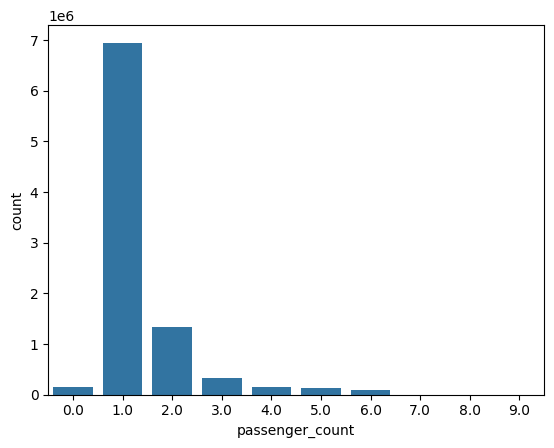

In [ ]:
sns.countplot(x="passenger_count",data=nyc_data)

In [ ]:
nyc_data[(nyc_data['passenger_count'] == 0) | (nyc_data['passenger_count'] >= 6)].count()

,0
vendorid,240940
pickup_datetime,240940
tpep_dropoff_datetime,240940
passenger_count,240940
trip_distance,240940
ratecodeid,240940
store_and_fwd_flag,240940
pickup_location_id,240940
dolocationid,240940
payment_type,240940


In [ ]:
nyc_data['vendorid'].value_counts()

,count
vendorid,
2,6659336
1,2488680


In [ ]:
exclude_indexes = nyc_data[(nyc_data['passenger_count'] == 0) | (nyc_data['passenger_count'] >= 6)].index
nyc_data.drop(exclude_indexes, inplace=True)
nyc_data.head(10)

,vendorid,pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pickup_location_id,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.0,0.5,0.00,0.0,1.0,14.30,2.5,0.0
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.0,0.5,4.00,0.0,1.0,16.90,2.5,0.0
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.0,0.5,3.28,0.0,1.0,19.68,2.5,0.0
5,2,2023-01-01 00:50:34,2023-01-01 01:02:52,1.0,1.84,1.0,N,161,137,1,12.8,1.0,0.5,10.00,0.0,1.0,27.80,2.5,0.0
6,2,2023-01-01 00:09:22,2023-01-01 00:19:49,1.0,1.66,1.0,N,239,143,1,12.1,1.0,0.5,3.42,0.0,1.0,20.52,2.5,0.0
7,2,2023-01-01 00:27:12,2023-01-01 00:49:56,1.0,11.70,1.0,N,142,200,1,45.7,1.0,0.5,10.74,3.0,1.0,64.44,2.5,0.0
8,2,2023-01-01 00:21:44,2023-01-01 00:36:40,1.0,2.95,1.0,N,164,236,1,17.7,1.0,0.5,5.68,0.0,1.0,28.38,2.5,0.0
9,2,2023-01-01 00:39:42,2023-01-01 00:50:36,1.0,3.01,1.0,N,141,107,2,14.9,1.0,0.5,0.00,0.0,1.0,19.90,2.5,0.0
10,2,2023-01-01 00:53:01,2023-01-01 01:01:45,1.0,1.80,1.0,N,234,68,1,11.4,1.0,0.5,3.28,0.0,1.0,19.68,2.5,0.0
11,1,2023-01-01 00:43:37,2023-01-01 01:17:18,4.0,7.30,1.0,N,79,264,1,33.8,3.5,0.5,7.75,0.0,1.0,46.55,2.5,0.0


### **Payment Types**

In [ ]:
print("Least Payment Type:",nyc_data['payment_type'].min())
print("Max Payment Type:",nyc_data['payment_type'].max())

In [ ]:
nyc_data['payment_type'].value_counts()


In [23]:
exclude_indexes_pay = nyc_data[nyc_data['payment_type'] == 5].index
nyc_data.drop(exclude_indexes_pay, inplace=True)

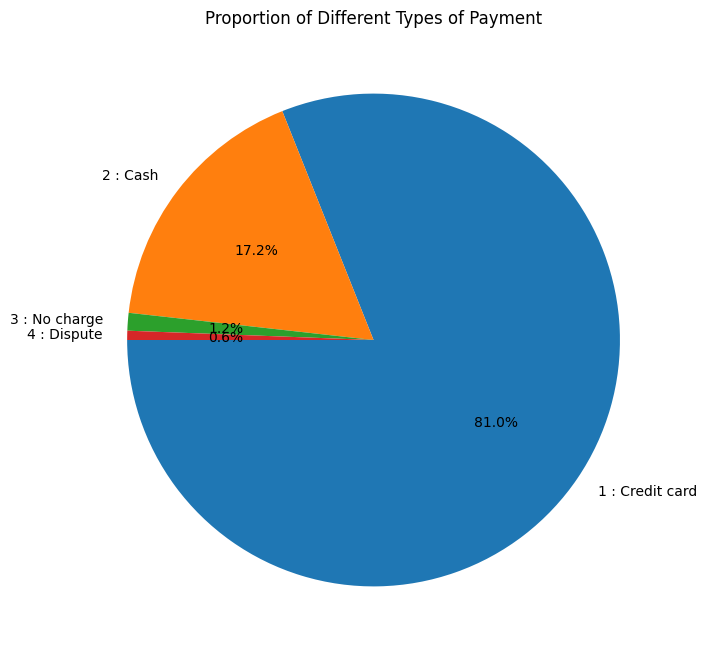

In [24]:
payment_counts = nyc_data['payment_type'].value_counts()

plt.figure(figsize=(8, 8))
labels = ['1 : Credit card',
'2 : Cash',
'3 : No charge',
'4 : Dispute',
]

plt.pie(payment_counts, labels=labels, autopct='%1.1f%%', startangle=180)
plt.title('Proportion of Different Types of Payment')
plt.show()

### **Total Amount**

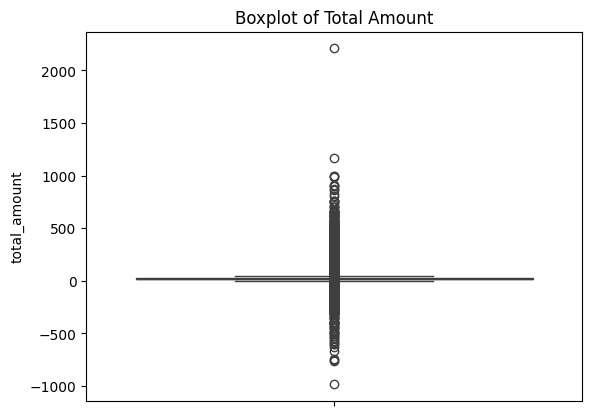

In [25]:
sns.boxplot(y="total_amount", data =nyc_data).set(title='Boxplot of Total Amount')
plt.show()

1. Median close to zero
2. Interquartile Range(IQR); height of box middle 50%
3. Whiskers: 1.5 times IQR. Outside this are outliers

In [26]:
#calculating total fare amount values at each percntile 0,10,20,30,40,50,60,70,80,90,100
print('-------------------------------------------------------------------------')
print('Analysing total amount feature of every ride')

for i in range(0,10):
    var = nyc_data["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))

for i in range(10,100,10):
    var = nyc_data["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))


#calculating total fare amount values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(91,100):
    var = nyc_data["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))


for i in np.arange(0.0, 1.0, 0.1):
    var =nyc_data["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

-------------------------------------------------------------------------
Analysing total amount feature of every ride
0 percentile value is -982.95
1 percentile value is 4.5
2 percentile value is 9.1
3 percentile value is 10.0
4 percentile value is 10.5
5 percentile value is 10.92
6 percentile value is 11.38
7 percentile value is 11.76
8 percentile value is 11.9
9 percentile value is 12.25
10 percentile value is 12.6
20 percentile value is 14.64
30 percentile value is 16.4
40 percentile value is 18.2
50 percentile value is 20.16
60 percentile value is 22.75
70 percentile value is 26.4
80 percentile value is 32.76
90 percentile value is 56.4
91 percentile value is 61.15
92 percentile value is 65.56
93 percentile value is 70.2
94 percentile value is 75.13
95 percentile value is 80.55
96 percentile value is 85.62
97 percentile value is 91.8
98 percentile value is 97.91
99 percentile value is 102.25
99.0 percentile value is 102.25
99.1 percentile value is 103.1
99.2 percentile value is 10

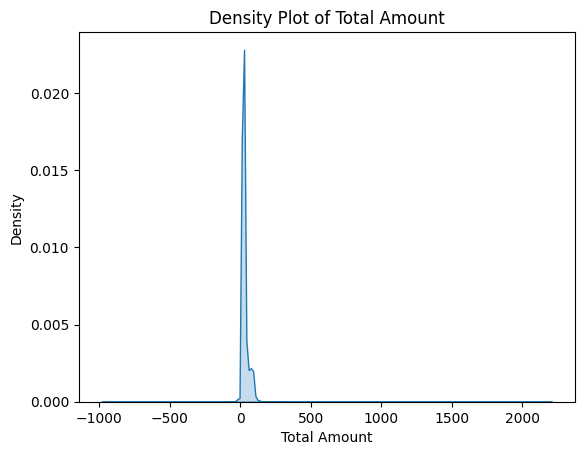

In [27]:
sns.kdeplot(nyc_data['total_amount'], fill=True)
plt.xlabel('Total Amount')
plt.ylabel('Density')
plt.title("Density Plot of Total Amount")
plt.show()

In [ ]:
# Filtering the negative and the most extreme values based on the percentile distribution observed
nyc_data = nyc_data[(nyc_data['total_amount'] > 0) & (nyc_data['total_amount'] <  500)]


In [ ]:
nyc_data.shape

### **Vendor ID**

As per NY Authority rule, there are only 2 Vendors.

In [ ]:
sns.catplot(x='vendorid', kind='count', data=nyc_data)

plt.xlabel('Vendor ID')
plt.ylabel('Count')
plt.title('Count of Rides by Vendor ID')
plt.show()

### **Pickup location ID**

In [ ]:
nyc_data[(nyc_data['pickup_location_id']<1) | (nyc_data['pickup_location_id']>265)]

From the above observation, there are no outliers.

### **Feature Engineering**

**Trip Duration** and **Average Speed during the ride**



In [32]:

def get_trip_duration_speed(month_data):
    # Convert pickup and dropoff to datetime, and then to Unix time directly using pandas
    month_data['pickup_datetime'] = pd.to_datetime(month_data['pickup_datetime'])
    month_data['tpep_dropoff_datetime'] = pd.to_datetime(month_data['tpep_dropoff_datetime'])

    # Calculate duration of trips in minutes
    month_data['trip_duration(mins)'] = round((month_data['tpep_dropoff_datetime'] - month_data['pickup_datetime']).dt.total_seconds() / 60.0,2)


    # Only include rows where the duration is positive
    month_data = month_data[month_data['trip_duration(mins)'] > 0]

    # Calculate speed in miles per hour
    month_data['avg_speed(mph)'] = round(60 * (month_data['trip_distance'] / month_data['trip_duration(mins)']),2)


    return month_data

print(nyc_data.shape)
nyc_data_eng  = get_trip_duration_speed(nyc_data)


(8391353, 19)


<ipython-input-32-1bbfa2e88bbc>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  month_data['avg_speed(mph)'] = round(60 * (month_data['trip_distance'] / month_data['trip_duration(mins)']),2)


In [ ]:
nyc_data_eng.shape

In [ ]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var =nyc_data_eng['trip_duration(mins)'].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))


#looking further from the 99th percecntile
for i in range(91,100):
    var =nyc_data_eng["trip_duration(mins)"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

**NY TLC Authority rule:**


According to NYC Taxi & Limousine Commision Regulations the maximum allowed trip duration in a 24 hour interval is 12 hours.

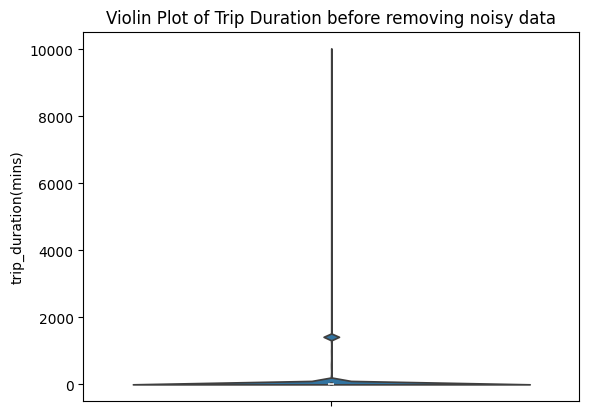

In [35]:
#Before removing the violated data (trip duration for a ride)

sns.violinplot(y="trip_duration(mins)", data=nyc_data_eng)
plt.title('Violin Plot of Trip Duration before removing noisy data')
plt.show()

The presence of a long tail indicates that although extended trips are feasible, they are somewhat infrequent.

As the time increases, the width of the violin gradually decreases, indicating a rapid decline in the frequency of longer trips.


In [ ]:
nyc_data_eng = nyc_data_eng [(nyc_data_eng['trip_duration(mins)']>0) & (nyc_data_eng['trip_duration(mins)']<720)]

In [ ]:
nyc_data_eng.shape

In [ ]:
#violinplot after removal of outliers
sns.violinplot(y="trip_duration(mins)", data=nyc_data_eng)
plt.title('Violin Plot of Trip Duration after removing anomalous data')
plt.show()

In [ ]:
sns.histplot(nyc_data_eng['trip_duration(mins)'], kde=True, bins=30)

# Labeling the axes and title
plt.xlabel('Trip Duration (mins)')
plt.ylabel('Count')
plt.title('Histogram with KDE of Trip Duration')

# Display the plot
plt.show()

**Speed**

**Checking percentile variations in speed(mph) feature**

In [ ]:
for i in range(0,100,10):
    var =nyc_data_eng["avg_speed(mph)"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))


#calculating speed values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =nyc_data_eng["avg_speed(mph)"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
#print("100 percentile value is ",var[-1])

#calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =nyc_data_eng["avg_speed(mph)"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

In [ ]:

# Strip plot of avg_speed(mph)
sns.stripplot(y='avg_speed(mph)', data=nyc_data_eng, jitter=True, alpha=0.5)


plt.ylabel('Average Speed (mph)')
plt.title('Strip Plot of Average Speed before outlier removal')


plt.show()


In [42]:
#avg.speed of cabs in New-York
sum(nyc_data_eng["avg_speed(mph)"]) / float(len(nyc_data_eng["avg_speed(mph)"]))

12.802471359966328

In [ ]:
nyc_data_eng[nyc_data_eng["avg_speed(mph)"] > 60].shape

In [ ]:
#Now cleaning the rows with speed greater than 60

nyc_data_eng=nyc_data_eng[(nyc_data_eng['avg_speed(mph)']>0) & (nyc_data_eng['avg_speed(mph)']<60)]

Cleaning the dataset with speed greater than 60mph on NY city roads.

In [ ]:
nyc_data_eng.shape

In [ ]:
nyc_data_eng.head()

### **Weather Data Cleaning**

In [ ]:
from datetime import datetime
from io import StringIO
import pandas as pd


In [ ]:
weather_df_jan = pd.read_csv('weather_data_jan_hourly.csv')

weather_df_feb = pd.read_csv('weather_data_feb_hourly.csv')

weather_df_mar = pd.read_csv('weather_data_march_hourly.csv')

weather_df = pd.concat([weather_df_jan,weather_df_feb,weather_df_mar])

weather_df.shape

In [49]:
weather_df.head()

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
0,"New York, NY, United States",2023-01-01T00:00:00,54.0,54.0,51.8,92.43,0.009,100,rain,0.0,...,1007.1,100.0,7.7,227,0.8,0,10,"Rain, Overcast",rain,"72505394728,KLGA,D2180,KNYC,72503014732"
1,"New York, NY, United States",2023-01-01T01:00:00,53.1,53.1,50.9,92.14,0.001,100,rain,0.0,...,1007.2,100.0,7.2,228,0.8,0,10,"Rain, Overcast",rain,"72505394728,KLGA,D2180,KNYC,72503014732"
2,"New York, NY, United States",2023-01-01T02:00:00,53.3,53.3,50.0,88.43,0.004,100,rain,0.0,...,1006.8,43.6,7.7,227,0.8,0,10,"Rain, Partially cloudy",rain,"72505394728,KLGA,D2180,KNYC,72503014732"
3,"New York, NY, United States",2023-01-01T03:00:00,52.6,52.6,49.7,89.82,0.000,0,NaN,0.0,...,1007.8,13.4,9.0,224,0.8,0,10,Clear,clear-night,"72505394728,KLGA,D2180,KNYC,72503014732"
4,"New York, NY, United States",2023-01-01T04:00:00,53.3,53.3,48.6,83.95,0.000,0,NaN,0.0,...,1008.1,7.2,9.9,222,0.8,0,10,Clear,clear-night,"72505394728,KLGA,D2180,KNYC,72503014732"


In [50]:
weather_df.isnull().sum()

,0
name,0
datetime,0
temp,0
feelslike,0
dew,0
humidity,0
precip,0
precipprob,0
preciptype,1805
snow,0


In [51]:
weather_df.drop(columns = ['preciptype'],inplace=True)

In [52]:
weather_df['datetime'] = pd.to_datetime(pd.to_datetime(weather_df['datetime']).dt.strftime("%Y-%m-%d %H:%M:%S"))


In [53]:
weather_df.head()

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,snow,snowdepth,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
0,"New York, NY, United States",2023-01-01 00:00:00,54.0,54.0,51.8,92.43,0.009,100,0.0,0.0,...,1007.1,100.0,7.7,227,0.8,0,10,"Rain, Overcast",rain,"72505394728,KLGA,D2180,KNYC,72503014732"
1,"New York, NY, United States",2023-01-01 01:00:00,53.1,53.1,50.9,92.14,0.001,100,0.0,0.0,...,1007.2,100.0,7.2,228,0.8,0,10,"Rain, Overcast",rain,"72505394728,KLGA,D2180,KNYC,72503014732"
2,"New York, NY, United States",2023-01-01 02:00:00,53.3,53.3,50.0,88.43,0.004,100,0.0,0.0,...,1006.8,43.6,7.7,227,0.8,0,10,"Rain, Partially cloudy",rain,"72505394728,KLGA,D2180,KNYC,72503014732"
3,"New York, NY, United States",2023-01-01 03:00:00,52.6,52.6,49.7,89.82,0.000,0,0.0,0.0,...,1007.8,13.4,9.0,224,0.8,0,10,Clear,clear-night,"72505394728,KLGA,D2180,KNYC,72503014732"
4,"New York, NY, United States",2023-01-01 04:00:00,53.3,53.3,48.6,83.95,0.000,0,0.0,0.0,...,1008.1,7.2,9.9,222,0.8,0,10,Clear,clear-night,"72505394728,KLGA,D2180,KNYC,72503014732"


In [54]:
nyc_data_eng['pickup_hour'] = nyc_data_eng['pickup_datetime'].dt.floor('H')

<ipython-input-54-b8c79a2c163b>:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  nyc_data_eng['pickup_hour'] = nyc_data_eng['pickup_datetime'].dt.floor('H')


In [55]:
nyc_data_eng.tail()

,vendorid,pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pickup_location_id,dolocationid,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration(mins),avg_speed(mph),pickup_hour
3316142,2,2023-03-31 23:56:39,2023-04-01 00:04:40,1.0,2.01,1.0,N,236,142,1,...,0.5,3.28,0.0,1.0,19.68,2.5,0.0,8.02,15.04,2023-03-31 23:00:00
3316143,2,2023-03-31 23:03:04,2023-03-31 23:05:49,1.0,0.36,1.0,N,48,48,1,...,0.5,2.02,0.0,1.0,12.12,2.5,0.0,2.75,7.85,2023-03-31 23:00:00
3316144,2,2023-03-31 23:18:13,2023-03-31 23:35:07,3.0,1.68,1.0,N,68,114,1,...,0.5,4.12,0.0,1.0,24.72,2.5,0.0,16.90,5.96,2023-03-31 23:00:00
3316145,2,2023-03-31 23:36:02,2023-03-31 23:44:47,1.0,1.50,1.0,N,114,137,1,...,0.5,2.00,0.0,1.0,17.70,2.5,0.0,8.75,10.29,2023-03-31 23:00:00
3316146,1,2023-03-31 23:40:16,2023-03-31 23:56:02,1.0,2.90,1.0,N,142,75,1,...,0.5,4.25,0.0,1.0,25.55,2.5,0.0,15.77,11.03,2023-03-31 23:00:00


### **Merging the weather data and the NYC taxi Dataset:**

In [56]:
nyc_taxi_merged = pd.merge(nyc_data_eng,weather_df[['datetime','temp','precip','windspeed','visibility']],left_on='pickup_hour',right_on='datetime',how='left')

In [57]:
nyc_taxi_merged.isnull().sum()

,0
vendorid,0
pickup_datetime,0
tpep_dropoff_datetime,0
passenger_count,0
trip_distance,0
ratecodeid,0
store_and_fwd_flag,0
pickup_location_id,0
dolocationid,0
payment_type,0


In [58]:
nyc_taxi_merged.drop(columns=['datetime'],inplace=True)

In [59]:
nyc_taxi_merged.head()

,vendorid,pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pickup_location_id,dolocationid,payment_type,...,total_amount,congestion_surcharge,airport_fee,trip_duration(mins),avg_speed(mph),pickup_hour,temp,precip,windspeed,visibility
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,...,14.30,2.5,0.0,8.43,6.90,2023-01-01,54.0,0.009,1.9,7.7
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,...,16.90,2.5,0.0,6.32,10.44,2023-01-01,54.0,0.009,1.9,7.7
2,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,...,19.68,2.5,0.0,10.83,7.92,2023-01-01,54.0,0.009,1.9,7.7
3,2,2023-01-01 00:50:34,2023-01-01 01:02:52,1.0,1.84,1.0,N,161,137,1,...,27.80,2.5,0.0,12.30,8.98,2023-01-01,54.0,0.009,1.9,7.7
4,2,2023-01-01 00:09:22,2023-01-01 00:19:49,1.0,1.66,1.0,N,239,143,1,...,20.52,2.5,0.0,10.45,9.53,2023-01-01,54.0,0.009,1.9,7.7


In [60]:
nyc_taxi_merged.shape

(8282969, 26)

In [61]:
#EDA
nyc_taxi_merged['Hour'] = nyc_taxi_merged['pickup_datetime'].dt.hour
nyc_taxi_merged['dayofweek'] = nyc_taxi_merged['pickup_datetime'].dt.dayofweek
nyc_taxi_merged['Month'] = nyc_taxi_merged['pickup_datetime'].dt.month

In [62]:
nyc_taxi_merged.head()

,vendorid,pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pickup_location_id,dolocationid,payment_type,...,trip_duration(mins),avg_speed(mph),pickup_hour,temp,precip,windspeed,visibility,Hour,dayofweek,Month
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,...,8.43,6.90,2023-01-01,54.0,0.009,1.9,7.7,0,6,1
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,...,6.32,10.44,2023-01-01,54.0,0.009,1.9,7.7,0,6,1
2,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,...,10.83,7.92,2023-01-01,54.0,0.009,1.9,7.7,0,6,1
3,2,2023-01-01 00:50:34,2023-01-01 01:02:52,1.0,1.84,1.0,N,161,137,1,...,12.30,8.98,2023-01-01,54.0,0.009,1.9,7.7,0,6,1
4,2,2023-01-01 00:09:22,2023-01-01 00:19:49,1.0,1.66,1.0,N,239,143,1,...,10.45,9.53,2023-01-01,54.0,0.009,1.9,7.7,0,6,1


In [63]:
plt.style.use('ggplot')

plt.rcParams['figure.figsize'] = [16, 10]

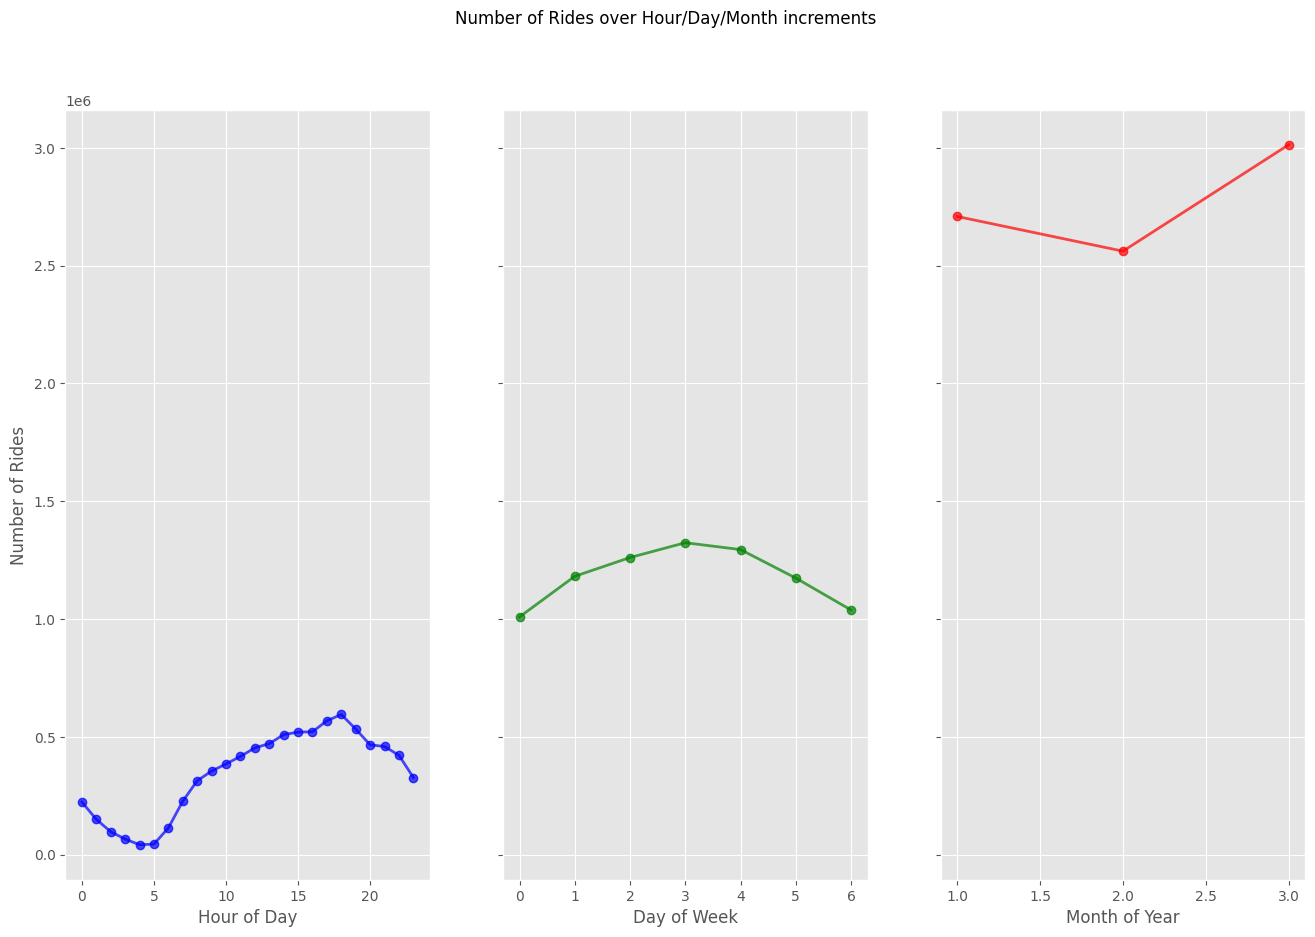

In [64]:
#Line plot
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(nyc_taxi_merged.groupby('Hour').count()['pickup_datetime'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(nyc_taxi_merged.groupby('dayofweek').count()['pickup_datetime'], 'go-', lw=2, alpha=0.7)
ax[2].plot(nyc_taxi_merged.groupby('Month').count()['pickup_datetime'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour of Day')
ax[1].set_xlabel('Day of Week')
ax[2].set_xlabel('Month of Year')
ax[0].set_ylabel('Number of Rides')
fig.suptitle('Number of Rides over Hour/Day/Month increments')
plt.show()

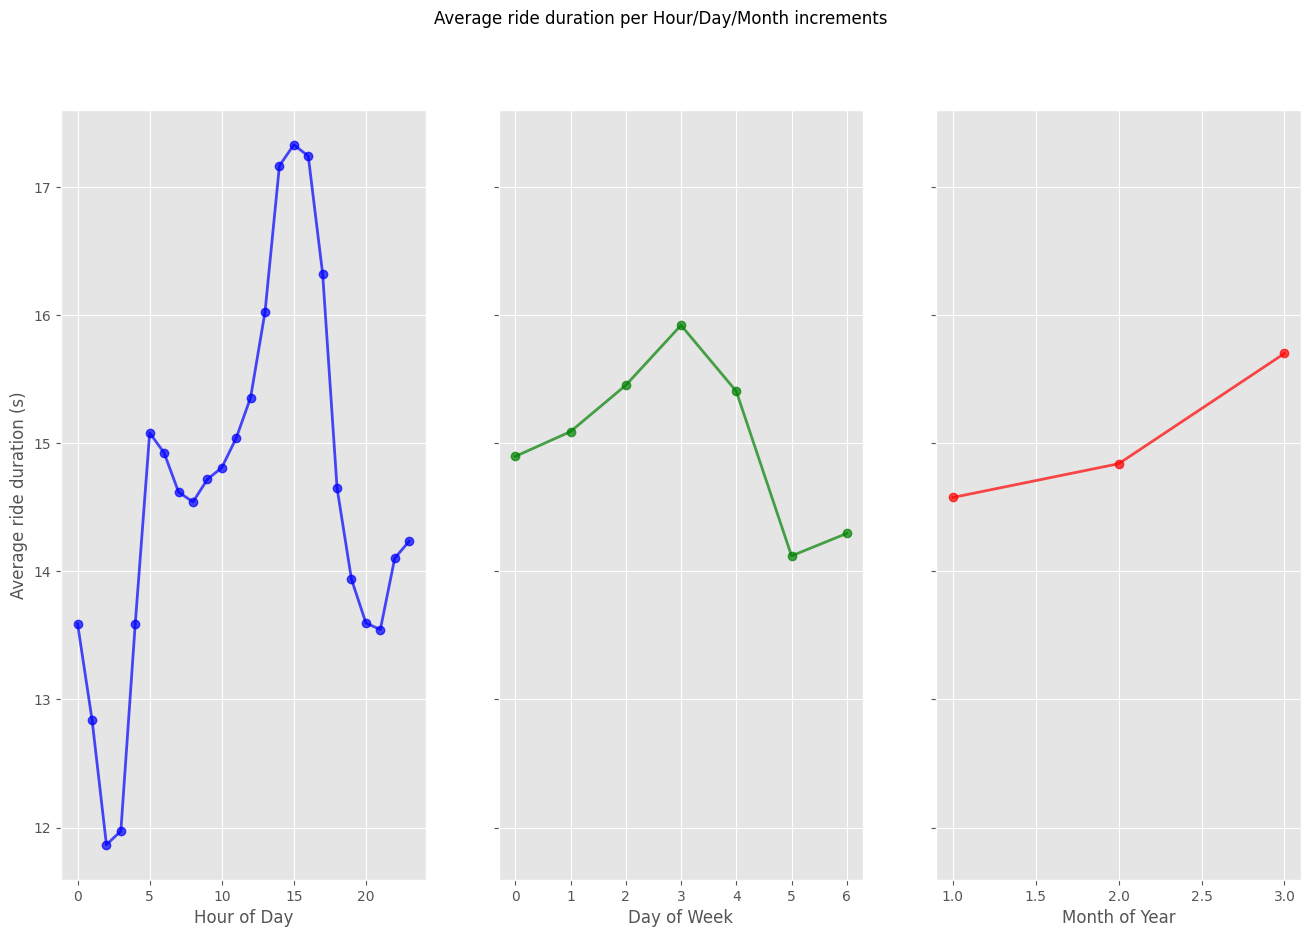

In [65]:
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(nyc_taxi_merged.groupby('Hour')['trip_duration(mins)'].mean(), 'bo-', lw=2, alpha=0.7)
ax[1].plot(nyc_taxi_merged.groupby('dayofweek')['trip_duration(mins)'].mean(), 'go-', lw=2, alpha=0.7)
ax[2].plot(nyc_taxi_merged.groupby('Month')['trip_duration(mins)'].mean(), 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour of Day')
ax[1].set_xlabel('Day of Week')
ax[2].set_xlabel('Month of Year')
ax[0].set_ylabel('Average ride duration (s)')
fig.suptitle('Average ride duration per Hour/Day/Month increments')
plt.show()

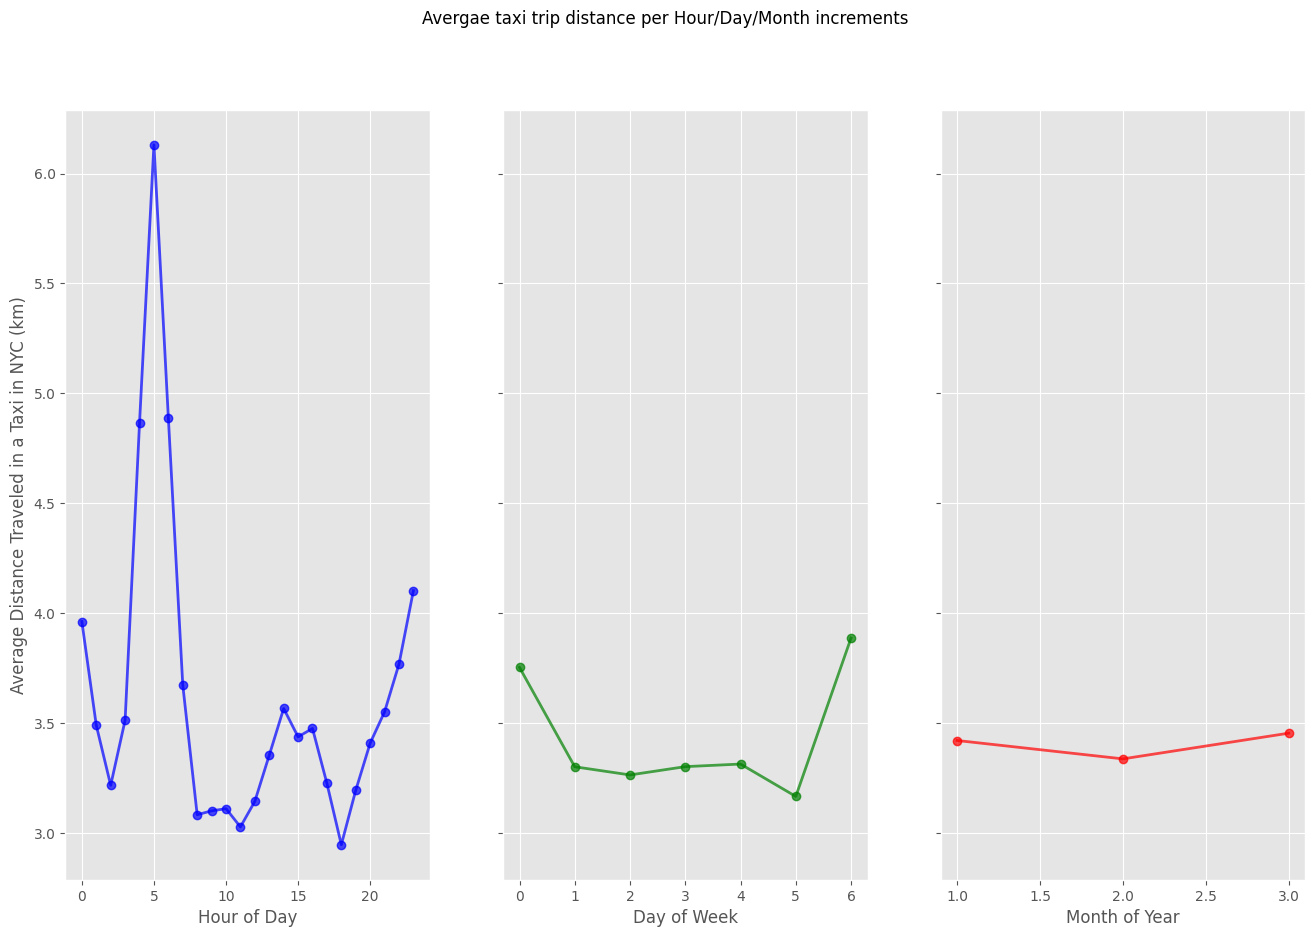

In [66]:
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(nyc_taxi_merged.groupby('Hour')['trip_distance'].mean(), 'bo-', lw=2, alpha=0.7)
ax[1].plot(nyc_taxi_merged.groupby('dayofweek')['trip_distance'].mean(), 'go-', lw=2, alpha=0.7)
ax[2].plot(nyc_taxi_merged.groupby('Month')['trip_distance'].mean(), 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour of Day')
ax[1].set_xlabel('Day of Week')
ax[2].set_xlabel('Month of Year')
ax[0].set_ylabel('Average Distance Traveled in a Taxi in NYC (km)')
fig.suptitle('Avergae taxi trip distance per Hour/Day/Month increments')
plt.show()

## **Data Preparation**

In [67]:
nyc_taxi_merged.columns

Index(['vendorid', 'pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'ratecodeid', 'store_and_fwd_flag',
       'pickup_location_id', 'dolocationid', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'congestion_surcharge',
       'airport_fee', 'trip_duration(mins)', 'avg_speed(mph)', 'pickup_hour',
       'temp', 'precip', 'windspeed', 'visibility', 'Hour', 'dayofweek',
       'Month'],
      dtype='object')

In [68]:
nyc_taxi_merged.head()

,vendorid,pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pickup_location_id,dolocationid,payment_type,...,trip_duration(mins),avg_speed(mph),pickup_hour,temp,precip,windspeed,visibility,Hour,dayofweek,Month
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,...,8.43,6.90,2023-01-01,54.0,0.009,1.9,7.7,0,6,1
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,...,6.32,10.44,2023-01-01,54.0,0.009,1.9,7.7,0,6,1
2,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,...,10.83,7.92,2023-01-01,54.0,0.009,1.9,7.7,0,6,1
3,2,2023-01-01 00:50:34,2023-01-01 01:02:52,1.0,1.84,1.0,N,161,137,1,...,12.30,8.98,2023-01-01,54.0,0.009,1.9,7.7,0,6,1
4,2,2023-01-01 00:09:22,2023-01-01 00:19:49,1.0,1.66,1.0,N,239,143,1,...,10.45,9.53,2023-01-01,54.0,0.009,1.9,7.7,0,6,1


In [69]:



# Grouping by 'pickup_hour' and 'pickup_location_id', then aggregating
nyc_agg_rides = nyc_taxi_merged.groupby(['pickup_hour', 'pickup_location_id']).agg({
    'passenger_count': 'sum',  # Total passengers per hour per location
    'trip_distance': 'sum',  # Total distance per hour per location
    'total_amount': 'sum',  # Total amount per hour per location
    'trip_duration(mins)': 'mean',  # Average trip duration
    'avg_speed(mph)': 'mean',  # Average speed
    'temp': 'mean',  # Average temperature
    'precip': 'mean',  # Average precipitation
    'windspeed': 'mean',  # Average wind speed
    'visibility': 'mean',  # Average visibility
    'dolocationid': 'count'  # Count of rides
}).reset_index()

# Rename aggregated columns
nyc_agg_rides.rename(columns={
    'passenger_count': 'total_passenger_count',
    'trip_distance': 'total_trip_distance',
    'total_amount': 'total_amount',
    'trip_duration(mins)': 'avg_trip_duration',
    'avg_speed(mph)': 'avg_speed',
    'temp': 'avg_temp',
    'precip': 'avg_precip',
    'windspeed': 'avg_windspeed',
    'visibility': 'avg_visibility',
    'dolocationid': 'total_rides'  # Renaming the count column to 'total_rides'
}, inplace=True)




In [70]:
nyc_agg_rides.head()

,pickup_hour,pickup_location_id,total_passenger_count,total_trip_distance,total_amount,avg_trip_duration,avg_speed,avg_temp,avg_precip,avg_windspeed,avg_visibility,total_rides
0,2023-01-01,4,21.0,45.80,381.90,16.100714,12.188571,54.0,0.009,1.9,7.7,14
1,2023-01-01,7,3.0,13.80,103.37,18.263333,15.066667,54.0,0.009,1.9,7.7,3
2,2023-01-01,12,1.0,1.90,20.52,10.550000,10.810000,54.0,0.009,1.9,7.7,1
3,2023-01-01,13,18.0,42.15,336.59,12.600000,14.213077,54.0,0.009,1.9,7.7,13
4,2023-01-01,24,18.0,37.51,290.34,11.729231,13.826154,54.0,0.009,1.9,7.7,13


In [71]:
nyc_agg_rides.shape

(189478, 12)

In [72]:
##Add missing hourly time slots
#For each pickup_location_id = Ensures every hourly time slot between the earliest and latest hour is present.
#Adds rows with zero values where no rides occurred.

from tqdm import tqdm

def add_missing_slots(nyc_agg_rides: pd.DataFrame) -> pd.DataFrame:

    location_ids = nyc_agg_rides['pickup_location_id'].unique()
    full_range = pd.date_range(
        nyc_agg_rides['pickup_hour'].min(), nyc_agg_rides['pickup_hour'].max(), freq='H')
    output = pd.DataFrame()
    for location_id in tqdm(location_ids):

        # keep only rides for this 'location_id'
        nyc_agg_rides_i = nyc_agg_rides[nyc_agg_rides['pickup_location_id'] == location_id]

        nyc_agg_rides_i.set_index('pickup_hour', inplace=True)
        nyc_agg_rides_i.index = pd.DatetimeIndex(nyc_agg_rides_i.index)
        nyc_agg_rides_i = nyc_agg_rides_i.reindex(full_range, fill_value=0)


        # add back `location_id` columns
        nyc_agg_rides_i['pickup_location_id'] = location_id

        output = pd.concat([output, nyc_agg_rides_i])

    #Turns the index back into a column called pickup_hour
    output = output.reset_index().rename(columns={'index': 'pickup_hour'})

    return output

In [73]:
nyc_agg_rides_all_slots = add_missing_slots(nyc_agg_rides)

<ipython-input-72-fbcae12d9935>:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(
100%|██████████| 260/260 [00:01<00:00, 130.05it/s]


In [74]:
nyc_agg_rides_all_slots.shape

(561600, 12)

In [75]:
def plot_rides(
    rides,
    locations
    ):
    """
    Line Plot for time-series data
    """
    rides_to_plot = rides[rides.pickup_location_id.isin(locations)] if locations else rides

    fig = px.line(
        rides_to_plot,
        x="pickup_hour",
        y="total_rides",
        color='pickup_location_id',
        template='none',
    )

    fig.show()

In [76]:
plot_rides(nyc_agg_rides_all_slots, locations=[43])

The function `get_cutoff_indices()` is used to **generate sliding window indices for time-series data**, helping to split the data into overlapping chunks for model training.

In [77]:
#Creating sliding window indices to split time series data into overlapping subsequences
def get_cutoff_indices(
    data: pd.DataFrame,
    n_features: int,
    step_size: int
    ) -> list:

        #Defines where the last possible target value can be.
        stop_position = len(data) - 1

        # Start the first sub-sequence at index position 0
        subseq_first_idx = 0 # Where the sequence starts.
        subseq_mid_idx = n_features # Where your input sequence ends.(hours)
        subseq_last_idx = n_features + 1 # One step ahead (target index).(1 hour forward)
        indices = [] # List to store all index triples.

        while subseq_last_idx <= stop_position:
            indices.append((subseq_first_idx, subseq_mid_idx, subseq_last_idx))

            subseq_first_idx += step_size
            subseq_mid_idx += step_size
            subseq_last_idx += step_size

        return indices

Preparing features (inputs) and targets (outputs) from NYC Taxi time-series data to predict future taxi demand (number of rides in the next hour).

In [78]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def calculate_weather_features_avg(last_3_hours_data):
    """
    Calculate averaged weather features for the last 3 hours.
    """
    return last_3_hours_data[['avg_temp', 'avg_precip', 'avg_windspeed', 'avg_visibility']].mean()

#Preparing the features(inputs) and targets(output lables)
def transform_ts_data_into_features_and_target(ts_data, input_seq_len, step_size):
    features = pd.DataFrame()
    targets = pd.DataFrame()

#Filtring data for each locations and sort data by pickup hour
    for location_id in tqdm(ts_data['pickup_location_id'].unique(), desc="Processing location IDs"):

        ts_data_one_location = ts_data[ts_data['pickup_location_id'] == location_id].sort_values('pickup_hour')

        #Using function  to get start, middle, and end indices for creating sequences
        indices = get_cutoff_indices(ts_data_one_location, input_seq_len, step_size)


        for idx in indices:
            start, mid, end = idx

            # Aggregates average of daily ride counts over the past 21 days
            daily_rides_agg_21days = ts_data_one_location.iloc[start:mid-168].resample('D', on='pickup_hour').agg({
                'total_rides': 'mean'
            })

            #Adds the last 168 hours (7 days) of hourly ride data
            hourly_rides_data_last7days = ts_data_one_location.iloc[mid - 168:end]['total_rides']

            # Calculate weather features for the last 3 hours of the window
            weather_features_avg = calculate_weather_features_avg(ts_data_one_location.iloc[mid-3:end])

            # Aggregate average for other features daily for 28 days
            daily_features_agg = ts_data_one_location[start:end].resample('D', on='pickup_hour').agg({
                'total_passenger_count': 'mean',
                'total_trip_distance': 'mean',
                'total_amount': 'mean',
                'avg_trip_duration': 'mean',
                'avg_speed': 'mean'
            })


            # Combining all Features together
            sequence_features = np.concatenate([
                daily_rides_agg_21days['total_rides'].values, #21 days of hourly average of total rides
                hourly_rides_data_last7days.values,  # Hourly rides of a week data for the sequence
                daily_features_agg['total_passenger_count'].values, # Daily aggregated features
                daily_features_agg['total_trip_distance'].values,
                daily_features_agg['total_amount'].values,
                daily_features_agg['avg_trip_duration'].values,
                daily_features_agg['avg_speed'].values,
                np.array([weather_features_avg['avg_temp']]),  # Averaged weather features for the last 3 hours, converted to 1D arrays
                np.array([weather_features_avg['avg_precip']]),
                np.array([weather_features_avg['avg_windspeed']]),
                np.array([weather_features_avg['avg_visibility']])
            ])

            #Saving the Feature Sequence and Target
            features = pd.concat([features, pd.DataFrame([sequence_features])], ignore_index=True)
            targets = pd.concat([targets, pd.DataFrame([ts_data_one_location['total_rides'].iloc[end]])], ignore_index=True)

    #Add column names to the features DataFrame
    daily_rides_cols = [f'rides_on_previous_{i+1}_day' for i in reversed(range(len(daily_rides_agg_21days['total_rides'].values))) ]
    hourly_rides_cols = [f'rides_on_previous_{i+1}_hour' for i in reversed(range(len(hourly_rides_data_last7days.values))) ]
    passenger_count_cols =  [f'avg_passenger_count_previous_{i+1}_day' for i in reversed(range(daily_features_agg.shape[0])) ]
    trip_distance_cols = [f'avg_trip_distance_previous_{i+1}_day' for i in reversed(range(daily_features_agg.shape[0])) ]
    total_amount_cols = [f'avg_total_amount_previous_{i+1}_day' for i in reversed(range(daily_features_agg.shape[0])) ]
    trip_duration_cols = [f'avg_trip_duration_previous_{i+1}_day' for i in reversed(range(daily_features_agg.shape[0])) ]
    speed_cols = [f'avg_speed_previous_{i+1}_day' for i in reversed(range(daily_features_agg.shape[0])) ]

    weather_cols = ['avg_temp_previous_3_hours','avg_precip_previous_3_hours','avg_windspeed_previous_3_hours','avg_visibility_previous_3_hours']

    feature_columns = daily_rides_cols + hourly_rides_cols + passenger_count_cols + trip_distance_cols + total_amount_cols +  trip_duration_cols + speed_cols + weather_cols

    features.columns = feature_columns

    # Rename target column
    targets.columns = ['target_rides_next_hour']

    return features, targets



In [ ]:
features,targets = transform_ts_data_into_features_and_target(
    nyc_agg_rides_all_slots,
    input_seq_len= 24*28*1, #consider one month of historical window
    step_size = 24 #Move the window by 24 hours (1 day)
)

print(f'Features shape={features.shape}')
print(f'Targets shape{targets.shape}')

Processing location IDs:  38%|███▊      | 100/260 [00:59<01:49,  1.46it/s]

In [ ]:
nyc_agg_rides_final_df = features.copy()
nyc_agg_rides_final_df['rides_next_hour_target'] = targets

In [ ]:
# Get the pickup hours for the rows that correspond to the 'nyc_agg_rides_final_df' DataFrame
pickup_hours_for_final_df = nyc_agg_rides_all_slots.loc[
    nyc_agg_rides_all_slots.index.isin(nyc_agg_rides_final_df.index), 'pickup_hour'
].values

# Assign these pickup hours to the 'nyc_agg_rides_final_df' DataFrame
nyc_agg_rides_final_df['pickup_hour'] = pickup_hours_for_final_df

In [ ]:
nyc_agg_rides_final_df.shape

In [ ]:
nyc_agg_rides_final_df.head()

In [ ]:
nyc_agg_rides_final_df.columns

In [ ]:
nyc_agg_rides_final_df.to_csv('final_dataset_nyc_agg.csv',index=False)


In [ ]:
#Libraries

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor
!pip install catboost
import catboost
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


In [ ]:
nyc_data_agg_final_df = pd.read_csv('final_dataset_nyc_agg.csv')

In [ ]:
nyc_data_agg_final_df.head()

In [ ]:
nyc_data_agg_final_df.shape

## **Train and Test data split**

In [ ]:
from datetime import datetime

def train_test_split(df,cutoff_date,target_column_name):

    df['pickup_hour'] = pd.to_datetime(df['pickup_hour'])

    train_data = df[df.pickup_hour < cutoff_date].reset_index(drop=True)
    test_data = df[df.pickup_hour >= cutoff_date].reset_index(drop=True)

    X_train = train_data.drop(columns=[target_column_name])
    X_train = X_train.iloc[:,:-2]
    y_train = train_data[target_column_name]
    X_test = test_data.drop(columns=[target_column_name])
    X_test = X_test.iloc[:,:-2]
    y_test = test_data[target_column_name]

    return X_train, y_train, X_test, y_test

In [ ]:
X_train, y_train, X_test, y_test = train_test_split(nyc_data_agg_final_df,datetime(2023, 3, 1, 0, 0, 0),"rides_next_hour_target")

## **Fitting XGBoost Model**

In [ ]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

xgb_predictions = xgb_model.predict(X_test)
xgb_predictions


## **Predictions and evaluating MAE**

In [ ]:
from sklearn.metrics import mean_absolute_error
test_mae_xgb = mean_absolute_error(y_test, xgb_predictions)
print(f'{test_mae_xgb=:.4f}')

In [ ]:
# Calculate MSE
test_mse_xgb = mean_squared_error(y_test, xgb_predictions)
print(f'{test_mse_xgb=:.4f}')

# Calculate RMSE
test_rmse_xgb = np.sqrt(test_mse_xgb)
print(f'{test_rmse_xgb=:.4f}')

## **Fitting LightGBM Model**

In [ ]:
lgb_model = lgb.LGBMRegressor()
lgb_model.fit(X_train, y_train)

lgb_predictions = lgb_model.predict(X_test)
lgb_predictions

test_mae_lgb = mean_absolute_error(y_test, lgb_predictions)
print(f'{test_mae_lgb=:.4f}')

In [ ]:
# Calculate MSE
test_mse_lgb = mean_squared_error(y_test, lgb_predictions)
print(f'{test_mse_lgb=:.4f}')

# Calculate RMSE
test_rmse_lgb = np.sqrt(test_mse_lgb)
print(f'{test_rmse_lgb=:.4f}')

## **Fitting CatBoost Model**

In [ ]:
catb_model = catboost.CatBoostRegressor(loss_function='MAE')
catb_model.fit(X_train, y_train)

In [ ]:
catb_predictions = catb_model.predict(X_test)
catb_predictions

test_mae_catb = mean_absolute_error(y_test, catb_predictions)
print(f'{test_mae_catb=:.4f}')

In [ ]:
# Calculate MSE
test_mse_catb = mean_squared_error(y_test, catb_predictions)
print(f'{test_mse_catb=:.4f}')

# Calculate RMSE
test_rmse_catb = np.sqrt(test_mse_catb)
print(f'{test_rmse_catb=:.4f}')

## **Fitting AdaBoost Model**

In [ ]:
adb_model = AdaBoostRegressor()
adb_model.fit(X_train, y_train)

adb_predictions = adb_model.predict(X_test)
adb_predictions

test_mae_adb = mean_absolute_error(y_test, adb_predictions)
print(f'{test_mae_adb=:.4f}')

In [ ]:
# Calculate MSE
test_mse_adb = mean_squared_error(y_test, adb_predictions)
print(f'{test_mse_adb=:.4f}')

# Calculate RMSE
test_rmse_adb = np.sqrt(test_mse_adb)
print(f'{test_rmse_adb=:.4f}')

##**MAE, MSE and RMSE value Comparision**

In [ ]:

data = [
    {"Model": "XGBoost Model", "MAE": 1.9232, "MSE": 249.6538, "RMSE": 15.8004},
    {"Model": "LightGBM Model", "MAE": 1.5360, "MSE": 134.6108, "RMSE": 11.6022},
    {"Model": "CatBoost Model", "MAE": 1.5284, "MSE": 169.7872, "RMSE": 13.0302},
    {"Model": "AdaBoost Model", "MAE": 11.9876, "MSE": 298.8525, "RMSE": 17.2874}
]

In [ ]:
# Creating DataFrame
df = pd.DataFrame(data)
df

Based on the MAE, CatBoost Model performed well with least MAE out of all those boosting techniques. Based on MSE and RMSE, LightGBM Model performed well

